In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

Data Loading

In [258]:
prem_data = pd.read_excel('premiums.xlsx')
prem_data.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [259]:
prem_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Age                    50000 non-null  int64 
 1   Gender                 50000 non-null  object
 2   Region                 50000 non-null  object
 3   Marital_status         50000 non-null  object
 4   Number Of Dependants   50000 non-null  int64 
 5   BMI_Category           50000 non-null  object
 6   Smoking_Status         49989 non-null  object
 7   Employment_Status      49998 non-null  object
 8   Income_Level           49987 non-null  object
 9   Income_Lakhs           50000 non-null  int64 
 10  Medical History        50000 non-null  object
 11  Insurance_Plan         50000 non-null  object
 12  Annual_Premium_Amount  50000 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 5.0+ MB


In [260]:
prem_data.dtypes

Age                       int64
Gender                   object
Region                   object
Marital_status           object
Number Of Dependants      int64
BMI_Category             object
Smoking_Status           object
Employment_Status        object
Income_Level             object
Income_Lakhs              int64
Medical History          object
Insurance_Plan           object
Annual_Premium_Amount     int64
dtype: object

DATA CLEANING:

1. REMOVE TRIMSPACE/ HANDLE DATA TYPES
2. REMOVE DUPLICATES
3. HANDLE MISSING VALUES
4. HANDLE OUTLIERS

In [261]:
#convert the column names into snake case
prem_data.columns = prem_data.columns.str.replace(" ","_").str.lower()

In [262]:
all_features= prem_data.columns
all_features

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

## REMOVE TRIMSPACE/ HANDLE DATA TYPES

In [263]:
prem_data= prem_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_4993/2006640918.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  prem_data= prem_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [264]:
prem_data.dtypes

age                       int64
gender                   object
region                   object
marital_status           object
number_of_dependants      int64
bmi_category             object
smoking_status           object
employment_status        object
income_level             object
income_lakhs              int64
medical_history          object
insurance_plan           object
annual_premium_amount     int64
dtype: object

In [265]:
prem_data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    50000 non-null  int64 
 1   gender                 50000 non-null  object
 2   region                 50000 non-null  object
 3   marital_status         50000 non-null  object
 4   number_of_dependants   50000 non-null  int64 
 5   bmi_category           50000 non-null  object
 6   smoking_status         49989 non-null  object
 7   employment_status      49998 non-null  object
 8   income_level           49987 non-null  object
 9   income_lakhs           50000 non-null  int64 
 10  medical_history        50000 non-null  object
 11  insurance_plan         50000 non-null  object
 12  annual_premium_amount  50000 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 26.1 MB


In [266]:
#change the premium amount into float
prem_data['annual_premium_amount']= prem_data['annual_premium_amount'].astype('float64')

## 2. REMOVE DUPLICATES

In [267]:
prem_data[prem_data.duplicated()]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount


No duplicates to drop

## 3. HANDLE MISSING VALUES

In [268]:
prem_data.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

There are so many ways to impute the missing values.

1. Mean Imputation
2. Median Imputation
3. Frequency count Imputation
4. Mode Imputation
5. Random Imputation
6. Target Based Imputation

Let us try to use different imputations for three of them

In [269]:
#let us deep dive into each
prem_data['smoking_status'].value_counts()

smoking_status
No Smoking        27366
Regular           15686
Occasional         6915
Smoking=0             8
Not Smoking           8
Does Not Smoke        6
Name: count, dtype: int64

In [270]:
prem_data['smoking_status'].replace({"Smoking=0": "No Smoking",
    "Not Smoking":"No Smoking",
    "Does Not Smoke":"No Smoking"},inplace=True)

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_4993/2672277990.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  prem_data['smoking_status'].replace({"Smoking=0": "No Smoking",


In [271]:
prem_data['smoking_status'].value_counts()

smoking_status
No Smoking    27388
Regular       15686
Occasional     6915
Name: count, dtype: int64

In [272]:
prem_data.groupby('bmi_category')['smoking_status'].value_counts(normalize=True)

bmi_category  smoking_status
Normal        No Smoking        0.577835
              Regular           0.294023
              Occasional        0.128143
Obesity       No Smoking        0.504048
              Regular           0.333613
              Occasional        0.162339
Overweight    No Smoking        0.469361
              Regular           0.373896
              Occasional        0.156742
Underweight   No Smoking        0.614473
              Regular           0.265903
              Occasional        0.119624
Name: proportion, dtype: float64

every bmi_category has more number of no smoking people , so there is no quite relationship so let us impute randomly

In [273]:
prem_data.notna().sum()

age                      50000
gender                   50000
region                   50000
marital_status           50000
number_of_dependants     50000
bmi_category             50000
smoking_status           49989
employment_status        49998
income_level             49987
income_lakhs             50000
medical_history          50000
insurance_plan           50000
annual_premium_amount    50000
dtype: int64

In [274]:
def random_imputation( dataset, column):
    df= dataset
    col= column
    missing_values_indices= df[df[col].isna()].index  
    sample_values= df[df[col].notna()].sample(df[col].isna().sum(), replace= True, random_state= 30)
    sample_values.index= missing_values_indices
    df.loc[missing_values_indices,col]= sample_values
    return df[col]
    

In [275]:
prem_data['smoking_status']= random_imputation(prem_data,'smoking_status')

In [276]:
prem_data['smoking_status'].isna().sum()

0

In [277]:
prem_data['income_level'].value_counts()

income_level
<10L         18667
10L - 25L    14391
25L - 40L    10288
> 40L         6641
Name: count, dtype: int64

In [278]:
#let us see whether income level depend on employment_status
prem_data.groupby('employment_status')['income_level'].value_counts(normalize= True, ascending=False)

employment_status  income_level
Freelancer         <10L            0.377245
                   10L - 25L       0.256467
                   25L - 40L       0.243566
                   > 40L           0.122723
Salaried           <10L            0.439420
                   10L - 25L       0.310580
                   25L - 40L       0.127647
                   > 40L           0.122353
Self-Employed      10L - 25L       0.288572
                   25L - 40L       0.283498
                   <10L            0.267392
                   > 40L           0.160538
Name: proportion, dtype: float64

In [279]:
def impute_incomelevel(row):
    col1= row['income_lakhs']
    col2= row['income_level']
    print(col1, col2)
    if pd.isna(col2)== False:
        return col2
    elif pd.isna(col2):
            if col1< 10:
                return '<10L'
            elif col1>=10 & col1 < 25:
                return '10L-25L'
            elif col1>=25 & col1 < 40:
                return '25L - 40L'
            else:
                return '> 40L'
       

In [280]:
prem_data[prem_data['income_level'].isna()]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
997,20,Female,Southeast,Unmarried,0,Normal,No Smoking,Self-Employed,NaN,5,No Disease,Bronze,7191.0
7094,33,Male,Southeast,Married,2,Normal,Regular,Self-Employed,NaN,7,High blood pressure,Silver,18335.0
15395,27,Female,Northeast,Unmarried,2,Underweight,No Smoking,Freelancer,NaN,5,No Disease,Silver,14469.0
15452,52,Male,Northeast,Married,3,Underweight,No Smoking,Freelancer,NaN,8,Thyroid,Silver,19535.0
17438,40,Female,Northeast,Married,4,Obesity,Regular,Self-Employed,NaN,8,High blood pressure,Silver,22392.0
18943,23,Female,Southwest,Unmarried,1,Underweight,No Smoking,NaN,NaN,8,No Disease,Bronze,5873.0
22553,37,Female,Southeast,Unmarried,0,Underweight,Regular,Salaried,NaN,7,High blood pressure,Silver,18631.0
24317,18,Male,Southwest,Married,3,Normal,Occasional,Freelancer,NaN,6,No Disease,Silver,8484.0
30421,39,Female,Southeast,Unmarried,2,Obesity,No Smoking,NaN,NaN,8,High blood pressure,Silver,20114.0
37325,19,Male,Southeast,Unmarried,0,Overweight,Occasional,Salaried,NaN,3,No Disease,Silver,9174.0


In [281]:
prem_data['income_level']= prem_data[['income_lakhs','income_level']].apply(impute_incomelevel, axis=1)

6 <10L
6 <10L
20 10L - 25L
77 > 40L
99 > 40L
14 10L - 25L
4 <10L
46 > 40L
21 10L - 25L
3 <10L
97 > 40L
21 10L - 25L
1 <10L
1 <10L
27 25L - 40L
20 10L - 25L
15 10L - 25L
18 10L - 25L
7 <10L
14 10L - 25L
37 25L - 40L
30 25L - 40L
13 10L - 25L
8 <10L
83 > 40L
15 10L - 25L
19 10L - 25L
29 25L - 40L
4 <10L
5 <10L
8 <10L
18 10L - 25L
27 25L - 40L
21 10L - 25L
70 > 40L
20 10L - 25L
11 10L - 25L
14 10L - 25L
33 25L - 40L
29 25L - 40L
8 <10L
21 10L - 25L
8 <10L
4 <10L
23 10L - 25L
3 <10L
40 25L - 40L
84 > 40L
4 <10L
8 <10L
22 10L - 25L
1 <10L
9 <10L
1 <10L
19 10L - 25L
1 <10L
27 25L - 40L
71 > 40L
59 > 40L
27 25L - 40L
97 > 40L
38 25L - 40L
3 <10L
20 10L - 25L
30 25L - 40L
35 25L - 40L
37 25L - 40L
5 <10L
28 25L - 40L
28 25L - 40L
39 25L - 40L
57 > 40L
5 <10L
1 <10L
4 <10L
5 <10L
5 <10L
20 10L - 25L
33 25L - 40L
9 <10L
25 10L - 25L
19 10L - 25L
12 10L - 25L
22 10L - 25L
12 10L - 25L
5 <10L
19 10L - 25L
11 10L - 25L
36 25L - 40L
15 10L - 25L
9 <10L
6 <10L
4 <10L
92 > 40L
25 25L - 40L
19 10L - 25

In [282]:
prem_data['income_level'].isna().sum()

0

In [283]:
prem_data['income_level'].value_counts()

income_level
<10L         18680
10L - 25L    14391
25L - 40L    10288
> 40L         6641
Name: count, dtype: int64

In [284]:
#let us check some randomly
prem_data.loc[[997,7094,15395,18943,30421], ["income_level","income_lakhs"]]

,income_level,income_lakhs
997,<10L,5
7094,<10L,7
15395,<10L,5
18943,<10L,8
30421,<10L,8


In [285]:
#smoking_status, income_level imputed successfully, let us impute employment_status now
prem_data['employment_status'].fillna(prem_data['employment_status'].mode().iloc[0], inplace=True)

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_4993/2641071521.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  prem_data['employment_status'].fillna(prem_data['employment_status'].mode().iloc[0], inplace=True)


In [286]:
prem_data['employment_status'].mode()

0    Salaried
Name: employment_status, dtype: object

In [287]:
prem_data['employment_status'].isna().sum()

0

## 4. HANDLE OUTLIERS

In [288]:
#Before looking for outliers, let us visualize each column
numerical_columns= list(prem_data.select_dtypes(include=['int64','float64']).columns)
numerical_columns


['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount']

In [289]:
categorical_columns= list(prem_data.select_dtypes(include=['object']).columns)
categorical_columns

['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status',
 'income_level',
 'medical_history',
 'insurance_plan']

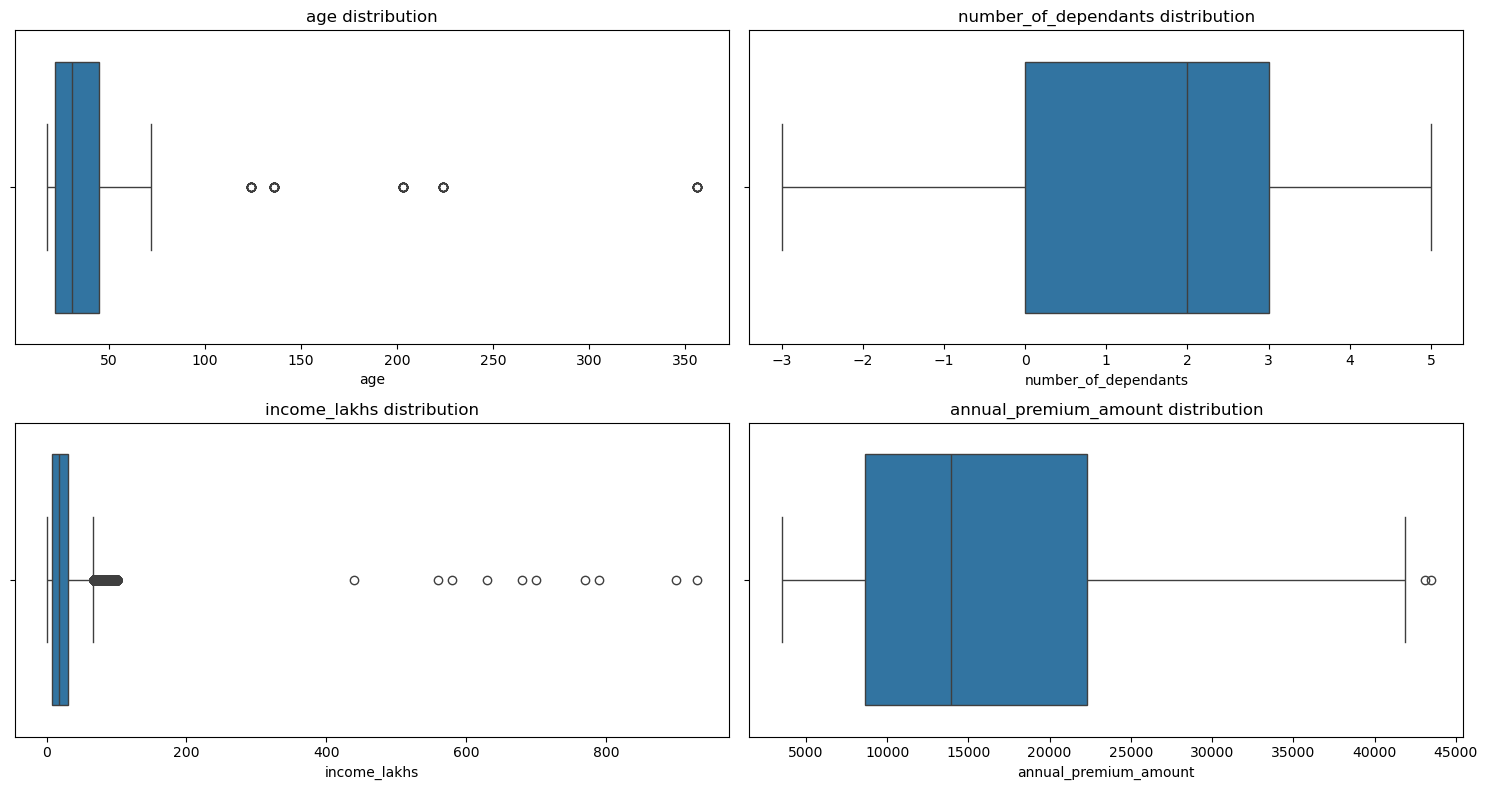

In [290]:
fig, axes= plt.subplots(2,2,figsize=(15,8))
axes= axes.flatten()
axes

for ax, col in zip(axes, numerical_columns):
    sns.boxplot(x= prem_data[col],ax = ax)
    ax.set_title(f'{col} distribution')
plt.tight_layout()
plt.show()

from the above figure age above 100 is not a valid so let us filter the records below 100

In [292]:
prem_data_filtered= prem_data[prem_data['age']<=100]

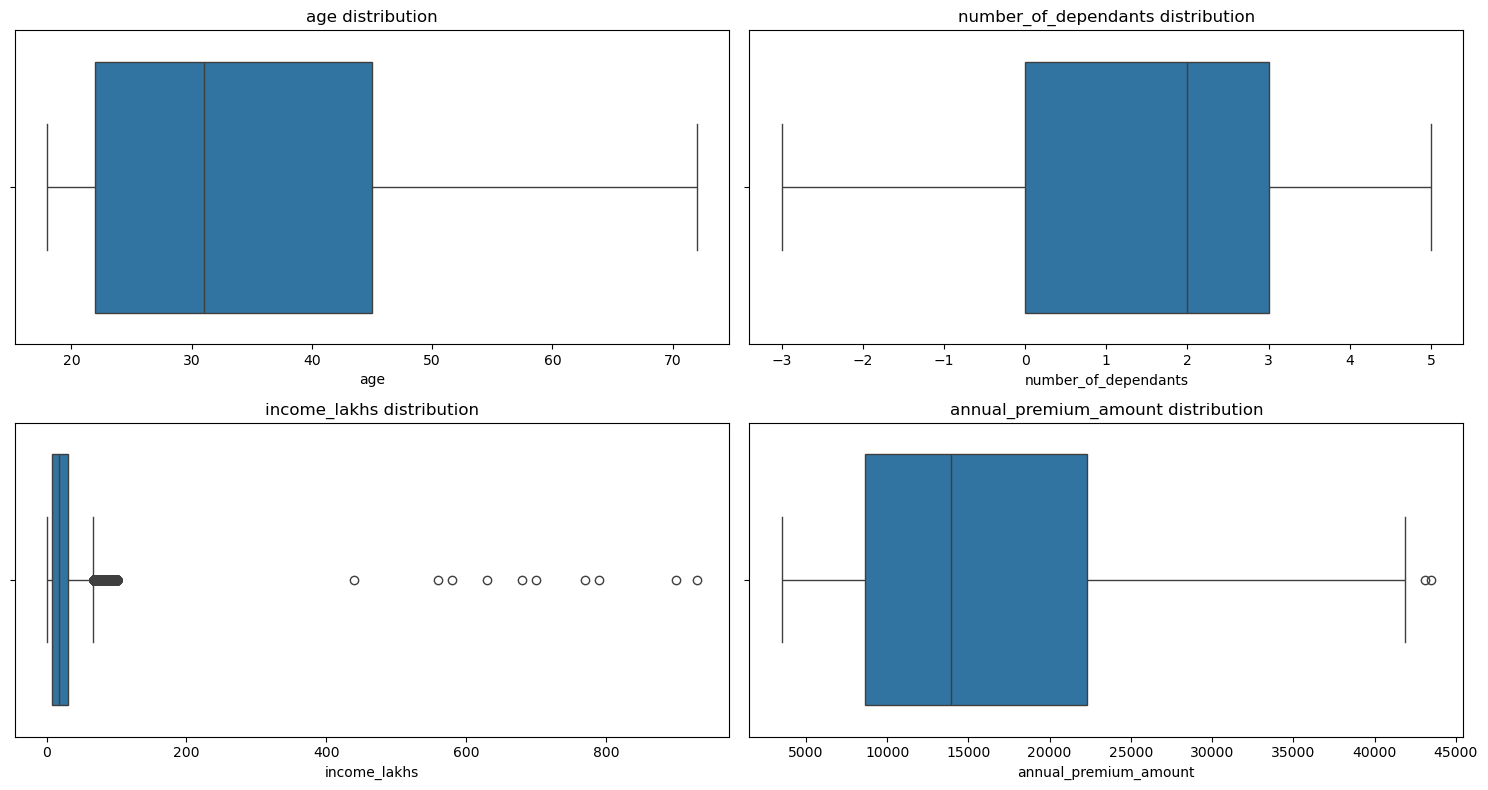

In [293]:
fig, axes= plt.subplots(2,2,figsize=(15,8))
axes= axes.flatten()
axes

for ax, col in zip(axes, numerical_columns):
    sns.boxplot(x= prem_data_filtered[col],ax = ax)
    ax.set_title(f'{col} distribution')
plt.tight_layout()
plt.show()

In [294]:
#Now let us find the IQR for income_lakhs
def quantile_calculation(col):
    Q1, Q3= col.quantile([0.25,0.75])
    IQR= Q3- Q1
    lower_bound = Q1- 1.5*IQR
    upper_bound= Q3+ 1.5*IQR
    return lower_bound,upper_bound
    

In [295]:
lf,hf=quantile_calculation(prem_data_filtered['income_lakhs'])
print(lf,hf)
prem_data_filtered[(prem_data_filtered['income_lakhs']<lf) | (prem_data_filtered['income_lakhs']> hf)].shape

-29.0 67.0


(3560, 13)

In [296]:
#as there are many records of outliers, after discusing with business team, decided to drop records at using quantile bound
threshold=prem_data_filtered['income_lakhs'].quantile(0.999) 
prem_data_filtered[prem_data_filtered['income_lakhs']>threshold].shape


(10, 13)

In [297]:
prem_data_filtered1=prem_data_filtered[prem_data_filtered['income_lakhs']<=threshold]

In [298]:
prem_data_filtered1.shape

(49932, 13)

## Univariate Analysis

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_4993/2485165952.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation= 90)


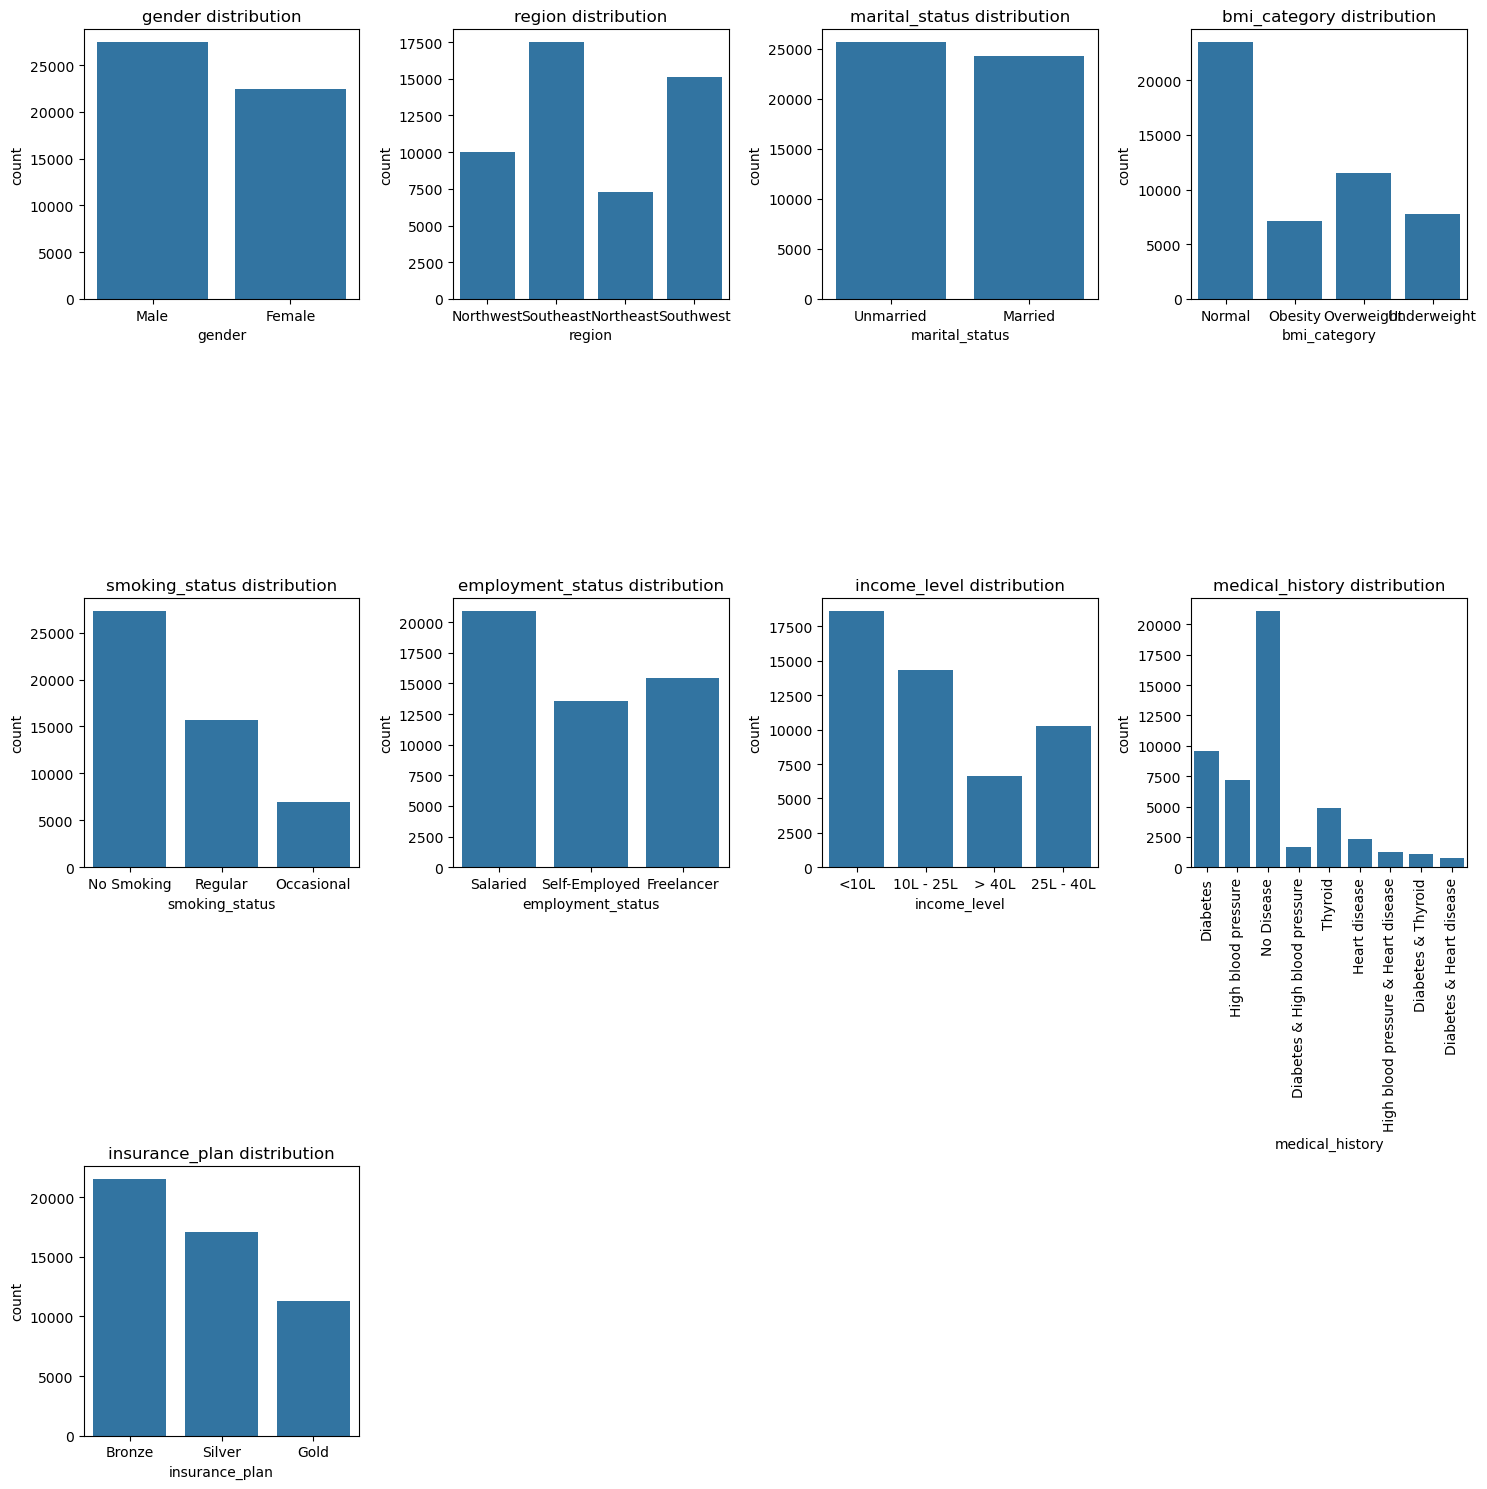

In [299]:
rows= 3
cols= (len(categorical_columns)//rows)+1
fig, axes= plt.subplots(rows,cols,figsize=(15,15))
axes= axes.flatten()
axes

for ax, col in zip(axes, categorical_columns):
    sns.countplot(x= prem_data_filtered1[col],ax = ax)
    ax.set_title(f'{col} distribution')
    if col== "medical_history":
        ax.set_xticklabels(ax.get_xticklabels(), rotation= 90)

for i in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[i]) 
    
plt.tight_layout()
plt.show()

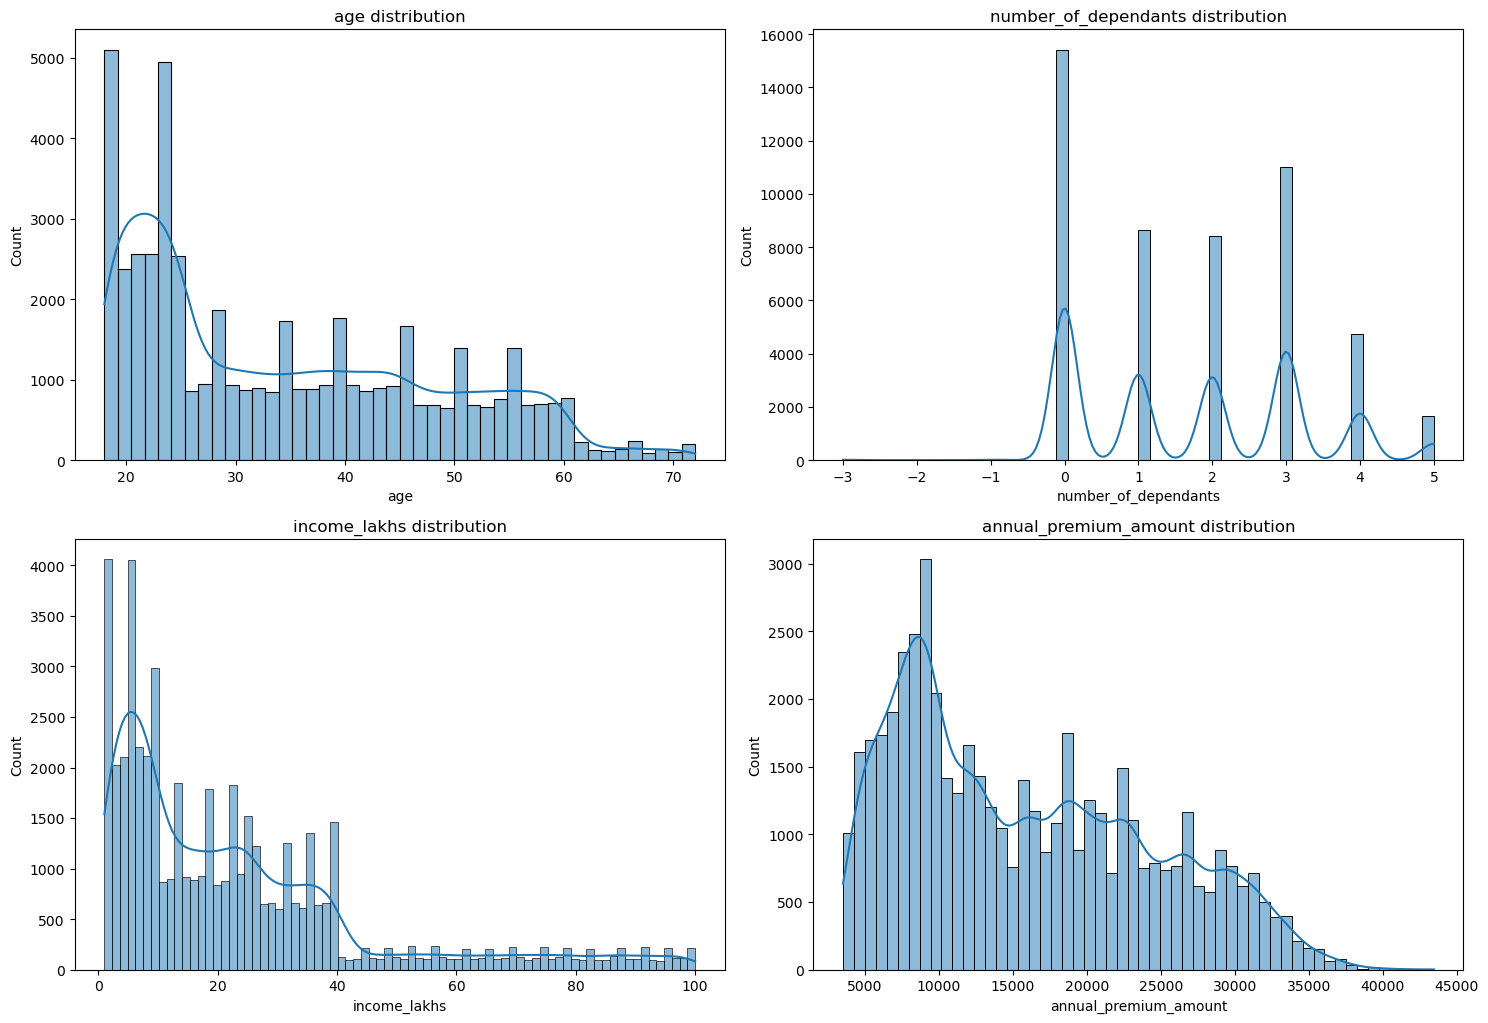

In [300]:
rows= 3
cols= (len(numerical_columns)//rows)+1
fig, axes= plt.subplots(rows,cols,figsize=(15,15))
axes= axes.flatten()
axes

for ax, col in zip(axes, numerical_columns):
    sns.histplot(x= prem_data_filtered1[col],ax = ax,kde=True)
    ax.set_title(f'{col} distribution')


for i in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[i]) 
    
plt.tight_layout()
plt.show()

As number_of_dependants are less than 0, make them absolute values.

In [301]:
prem_data_filtered1['number_of_dependants']=prem_data_filtered1['number_of_dependants'].abs()

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_4993/2138320173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_data_filtered1['number_of_dependants']=prem_data_filtered1['number_of_dependants'].abs()


## Bi Variate Analysis

In [302]:
crosstab=pd.crosstab(prem_data_filtered1['marital_status'],prem_data_filtered1['smoking_status'])

<Axes: xlabel='marital_status'>

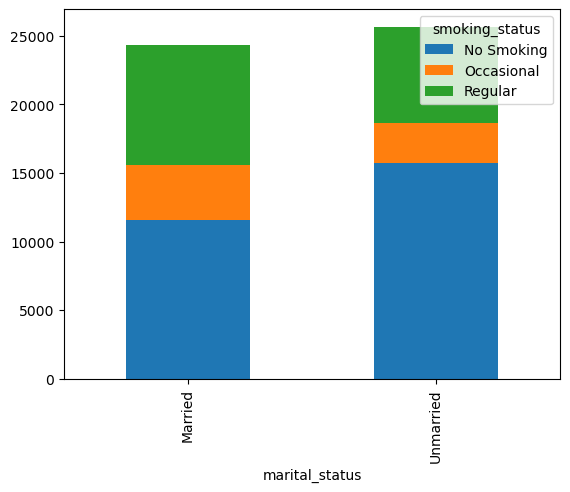

In [303]:
crosstab.plot(kind="bar",stacked=True)

<Axes: xlabel='smoking_status', ylabel='marital_status'>

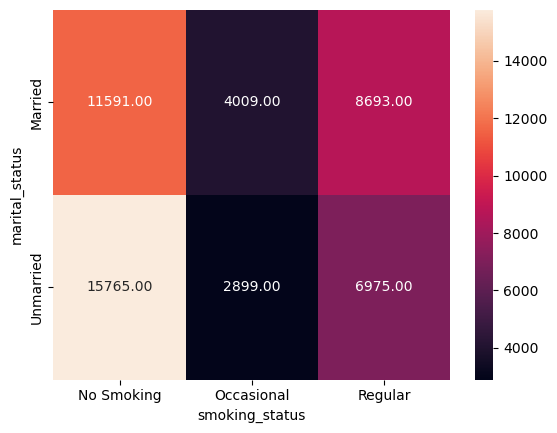

In [304]:
sns.heatmap(crosstab, annot=True,fmt=".2f")

In [305]:
numerical_columns

['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount']

<Axes: xlabel='number_of_dependants', ylabel='age'>

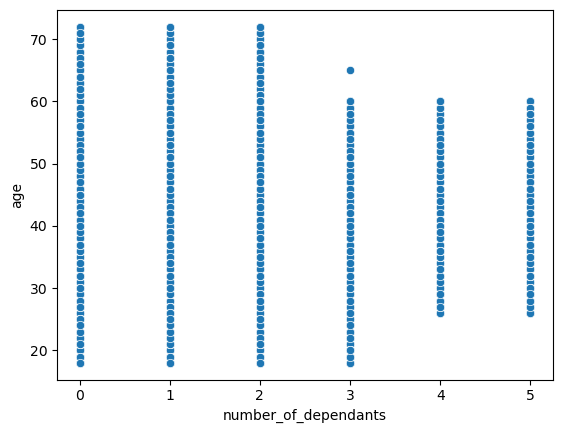

In [306]:
sns.scatterplot(y='age',x='number_of_dependants',data=prem_data_filtered1)

## Encode the categorical columns

In [307]:
categorical_columns

['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status',
 'income_level',
 'medical_history',
 'insurance_plan']

In [308]:
prem_data_filtered1['medical_history'].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [309]:
risk_score={
"diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0 
}


In [310]:
prem_data_filtered1[['dis1', 
                     'dis2']]= prem_data_filtered1['medical_history'].str.split('&',expand=True).apply(lambda x: x.str.lower())


/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_4993/4268426606.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_data_filtered1[['dis1',
/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_4993/4268426606.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_data_filtered1[['dis1',


In [311]:
prem_data_filtered1['dis1'].fillna('none', inplace=True)
prem_data_filtered1['dis2'].fillna('none', inplace=True)

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_4993/50144401.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  prem_data_filtered1['dis1'].fillna('none', inplace=True)
/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_4993/50144401.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_data_filtered1['dis1'].fillna('no

In [312]:
prem_data_filtered1['risk_score']= 0

def calculate_total_risk_score(row):
    disease1= row['dis1'].strip()
    disease2= row['dis2'].strip()
    score1= risk_score[disease1]
    score2= risk_score[disease2]
    return score1+ score2
    


/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_4993/1736859144.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_data_filtered1['risk_score']= 0


In [313]:
prem_data_filtered1['risk_score']=prem_data_filtered1[['dis1','dis2']].apply(calculate_total_risk_score, axis=1)

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_4993/3616989725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_data_filtered1['risk_score']=prem_data_filtered1[['dis1','dis2']].apply(calculate_total_risk_score, axis=1)


In [314]:
max_score= prem_data_filtered1['risk_score'].max()
min_score= prem_data_filtered1['risk_score'].min()
prem_data_filtered1['normalized_score']= (prem_data_filtered1['risk_score']- min_score)/(max_score-min_score)
prem_data_filtered1.head()

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_4993/20049080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_data_filtered1['normalized_score']= (prem_data_filtered1['risk_score']- min_score)/(max_score-min_score)


,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,dis1,dis2,risk_score,normalized_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053.0,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339.0,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164.0,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303.0,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365.0,high blood pressure,none,6,0.428571


In [315]:
prem_data_filtered1.drop(columns= ['dis1','dis2','risk_score','medical_history'],inplace=True)

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_4993/534884300.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_data_filtered1.drop(columns= ['dis1','dis2','risk_score','medical_history'],inplace=True)


In [316]:
categorical_columns=list(prem_data_filtered1.select_dtypes(include='object').columns)
categorical_columns

['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status',
 'income_level',
 'insurance_plan']

In [317]:
prem_data_filtered1['income_level'].value_counts()

income_level
<10L         18658
10L - 25L    14371
25L - 40L    10278
> 40L         6625
Name: count, dtype: int64

In [318]:
prem_data_filtered1['income_level']= prem_data_filtered1['income_level'].map({'<10L':1,'10L - 25L': 2, '25L - 40L':3, '> 40L':4})
prem_data_filtered1['insurance_plan']= prem_data_filtered1['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_4993/2861020348.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_data_filtered1['income_level']= prem_data_filtered1['income_level'].map({'<10L':1,'10L - 25L': 2, '25L - 40L':3, '> 40L':4})
/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_4993/2861020348.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_data_filtered1['insurance_plan']= prem_data_filtered1['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})


In [319]:
#for all the nominal_columns do one hot encoding
nominal_columns= ['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status']
prem_data_filtered2= pd.get_dummies(prem_data_filtered1, columns=nominal_columns, drop_first= True,dtype=int)
prem_data_filtered2.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164.0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,2,13365.0,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


## Feature Scaling/Selection

In [320]:
prem_data_filtered2.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'normalized_score',
       'gender_Male', 'region_Northwest', 'region_Southeast',
       'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

<Axes: >

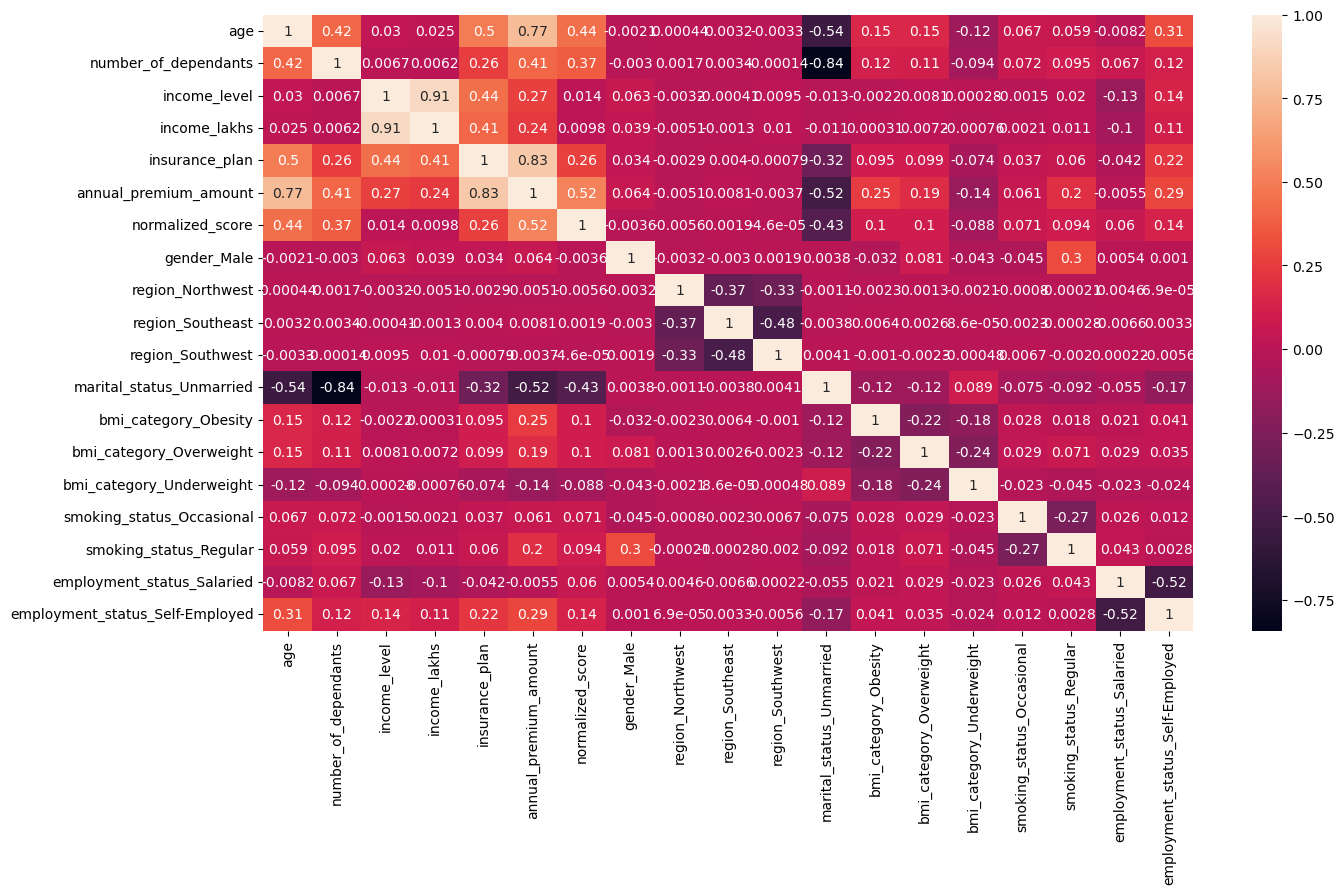

In [322]:
correlation_matrix= prem_data_filtered2.corr()
plt.figure(figsize=(15,8))
sns.heatmap(correlation_matrix, annot= True)

In [323]:
X= prem_data_filtered2.drop(columns='annual_premium_amount')
y= prem_data_filtered2['annual_premium_amount']

In [324]:
X.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'normalized_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [325]:
columns_to_scale=['age','number_of_dependants','income_level','income_lakhs','insurance_plan']


In [326]:
from sklearn.preprocessing import MinMaxScaler

In [327]:
scaler= MinMaxScaler()
X[columns_to_scale]= scaler.fit_transform(X[columns_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,49932.000000,49932.000000,49932.000000,49932.000000,49932.000000,49932.000000,49932.000000,49932.000000,49932.000000,49932.000000,49932.000000,49932.000000,49932.000000,49932.000000,49932.000000,49932.000000,49932.000000,49932.00000
mean,0.303766,0.343575,0.365844,0.221081,0.397471,0.291860,0.549607,0.200853,0.350336,0.303132,0.513478,0.143175,0.231194,0.155391,0.138348,0.313787,0.419430,0.27205
std,0.253377,0.298418,0.349720,0.223928,0.392440,0.287434,0.497538,0.400642,0.477080,0.459616,0.499823,0.350254,0.421601,0.362281,0.345268,0.464035,0.493471,0.44502
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.074074,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.240741,0.400000,0.333333,0.161616,0.500000,0.357143,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,0.500000,0.600000,0.666667,0.303030,0.500000,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [328]:
#let us check for multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df= pd.DataFrame()
    vif_df['Column']= data.columns
    vif_df['VIF']= [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

In [330]:
vif_df=calculate_vif(X)
vif_df.sort_values('VIF', ascending=False)

,Column,VIF
2,income_level,12.448854
3,income_lakhs,11.183596
0,age,4.567443
1,number_of_dependants,4.534641
4,insurance_plan,3.585450
10,marital_status_Unmarried,3.410382
8,region_Southeast,2.921657
5,normalized_score,2.688250
9,region_Southwest,2.670915
6,gender_Male,2.421119


As income_level and income_lakhs both explain the same thing, the variance_inflation_factor is high, let us drop one

In [331]:
calculate_vif(X.drop(columns='income_level'))

,Column,VIF
0,age,4.545678
1,number_of_dependants,4.526625
2,income_lakhs,2.480284
3,insurance_plan,3.446456
4,normalized_score,2.687958
5,gender_Male,2.409614
6,region_Northwest,2.100185
7,region_Southeast,2.919036
8,region_Southwest,2.668561
9,marital_status_Unmarried,3.392985


Now everything looks good

In [332]:
X_reduced= X.drop(columns='income_level')
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


## Model Building

In [333]:
X_train, X_test, y_train, y_test= train_test_split(X_reduced, y, test_size=0.2, random_state=30)

In [334]:
print("X_train shape",X_train.shape)
print("X_test shape",X_test.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)

X_train shape (39945, 17)
X_test shape (9987, 17)
y_train shape (39945,)
y_test shape (9987,)


## Linear Regression

In [335]:
from sklearn.linear_model import LinearRegression

In [336]:
linear_model= LinearRegression()
linear_model.fit(X_train, y_train)

#check for scores (R2)
test_score= linear_model.score(X_test, y_test)
train_score= linear_model.score(X_train, y_train)
print(train_score,test_score)

0.9284219800691593 0.9272533265836693


In [337]:
#check for mse and rmse

y_pred= linear_model.predict(X_test)
mse=mean_squared_error(y_test, y_pred)
rmse= np.sqrt(mse)
print("MSE for linear Regression", mse, "RMSE for linear regression", rmse)

MSE for linear Regression 5142286.260228827 RMSE for linear regression 2267.6609667736548


## Random Forest Regressor

In [339]:
from sklearn.ensemble import RandomForestRegressor

In [340]:
rf_model= RandomForestRegressor(n_estimators=100, criterion= 'squared_error',max_depth =4,random_state=30)
rf_model.fit(X_train, y_train)

rf_test_score= rf_model.score(X_test, y_test)
rf_train_score= rf_model.score(X_train, y_train)
print(rf_test_score,rf_train_score)

0.92925647157218 0.9292927832445301


In [341]:
#check for mse and rmse
rf_preds= rf_model.predict(X_test)
rf_mse= mean_squared_error(y_test,rf_preds)
rf_rmse= np.sqrt(rf_mse)
print("MSE for Random Forest Regressor", rf_mse, "RMSE for Random Forest Regressor", rf_rmse)

MSE for Random Forest Regressor 5000688.789610286 RMSE for Random Forest Regressor 2236.2219902349334


## XGBoost Regressor

In [342]:
from xgboost import XGBRegressor

In [343]:
xgb_model= XGBRegressor(n_estimators= 50, max_depth= 5)
xgb_model.fit(X_train, y_train)


xgb_test_score= xgb_model.score(X_test, y_test)
xgb_train_score= xgb_model.score(X_train, y_train)
print(xgb_test_score,xgb_train_score)

0.9814467021238524 0.9830970500117143


In [344]:
xgb_preds= xgb_model.predict(X_test)
xgb_mse= mean_squared_error(y_test, xgb_preds)
xgb_rmse= np.sqrt(xgb_mse)
print("MSE for XGBoost Regressor", xgb_mse, "RMSE for XGBoost Regressor", xgb_rmse)

MSE for XGBoost Regressor 1311487.718543959 RMSE for XGBoost Regressor 1145.2020426736756


Out of three models XGBoost performed better, let us do hyper parameter tuning for the model

## Hyper Paramter tuning

In [345]:
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}


In [346]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,              # Try 50 different combinations
    scoring='neg_mean_squared_error',
    cv=5,                   # 5-fold cross-validation
    verbose=2,
    random_state=30,
    n_jobs=-1               # Use all available cores
)

random_search.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          multi_strategy=None, n_estimators=50,
                                          n_jobs=None, num_parallel_tree=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 8, 10],
                                        'n_estimators': [100, 200, 300, 500],
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=30, scoring='neg_mean_squared_error',
                   verbose=2)

In [348]:
best_params=random_search.best_params_
best_params

{'subsample': 0.8,
 'reg_lambda': 1.5,
 'reg_alpha': 1,
 'n_estimators': 100,
 'max_depth': 5,
 'learning_rate': 0.1,
 'colsample_bytree': 1.0}

[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=1.5, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=8, n_estimators=300, reg_alpha=0.1, reg_lambda=1.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=8, n_estimators=300, reg_alpha=0.1, reg_lambda=1.5, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, reg_alpha=1, reg_lambda=1.5, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=4, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; tota

In [350]:
#now train the model based on this params
xgb_model_opt= XGBRegressor(n_estimators= best_params['n_estimators'], max_depth= best_params['max_depth'],
                            reg_lambda= best_params['reg_lambda'],
                           reg_alpha=best_params['reg_alpha'],
                           learning_rate=best_params['learning_rate'],
                           colsample_bytree=best_params['colsample_bytree'])
xgb_model_opt.fit(X_train, y_train)


xgb_test_score_opt= xgb_model_opt.score(X_test, y_test)
xgb_train_score_opt= xgb_model_opt.score(X_train, y_train)
print(xgb_test_score_opt,xgb_train_score_opt)

0.981591737988994 0.9826681597578935


In [351]:
xgb_preds_opt= xgb_model_opt.predict(X_test)
xgb_mse_opt= mean_squared_error(y_test, xgb_preds_opt)
xgb_rmse_opt= np.sqrt(xgb_mse_opt)
print("MSE for XGBoost Regressor", xgb_mse_opt, "RMSE for XGBoost Regressor", xgb_rmse_opt)

MSE for XGBoost Regressor 1301235.4842969123 RMSE for XGBoost Regressor 1140.7170921384989


In [352]:
residuals_df=pd.DataFrame({
  'actual': y_test,
'pred': xgb_preds_opt,
'residual': xgb_preds_opt-y_test,
'percentage': ((xgb_preds_opt-y_test)/(y_test))*100
})
residuals_df

,actual,pred,residual,percentage
42260,26247.0,26634.634766,387.634766,1.476873
34268,13113.0,14255.872070,1142.872070,8.715565
17902,13362.0,10059.913086,-3302.086914,-24.712520
33140,8218.0,9976.182617,1758.182617,21.394288
28875,27750.0,27452.179688,-297.820312,-1.073226
...,...,...,...,...
17443,15383.0,15649.591797,266.591797,1.733029
46356,28604.0,29241.072266,637.072266,2.227214
26731,29803.0,29668.982422,-134.017578,-0.449678
41081,7444.0,9843.863281,2399.863281,32.238894


In [357]:
threshold_res= 10
extreme_residuals=residuals_df[residuals_df['percentage']>threshold_res]
extreme_residuals.shape

(1524, 4)

In [358]:
print(extreme_residuals.shape[0]/X_test.shape[0])


0.15259837789125863


so for more than 15% percentages we will evaluate premium amount differ by 10%.

In [359]:
extreme_residuals.index

Index([33140, 15603,  5746, 38696, 37867, 22929, 42980, 20752, 38888, 15405,
       ...
       33633, 34119,  2782, 19336, 22095,  3333,  4716, 46138, 46759, 41081],
      dtype='int64', length=1524)

In [362]:
extreme_errors= X_test.loc[extreme_residuals.index]
extreme_errors

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
33140,0.074074,0.2,0.151515,0.5,0.0,0,0,0,1,1,0,0,1,0,0,0,0
15603,0.055556,0.0,0.303030,0.0,0.0,1,0,0,1,1,0,0,0,0,0,0,0
5746,0.111111,0.0,0.020202,0.0,0.0,1,0,0,1,1,0,0,0,1,0,0,0
38696,0.111111,0.4,0.070707,0.5,0.0,1,0,0,1,1,0,0,0,0,0,1,0
37867,0.111111,0.2,0.010101,0.0,0.0,0,0,0,1,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3333,0.074074,0.4,0.202020,0.5,0.0,1,0,0,1,0,0,0,0,1,0,0,1
4716,0.018519,0.0,0.080808,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,1
46138,0.129630,0.2,0.191919,0.0,0.0,1,0,1,0,1,0,0,1,0,1,1,0
46759,0.000000,0.0,0.000000,0.0,0.0,0,0,1,0,1,0,0,0,0,0,1,0


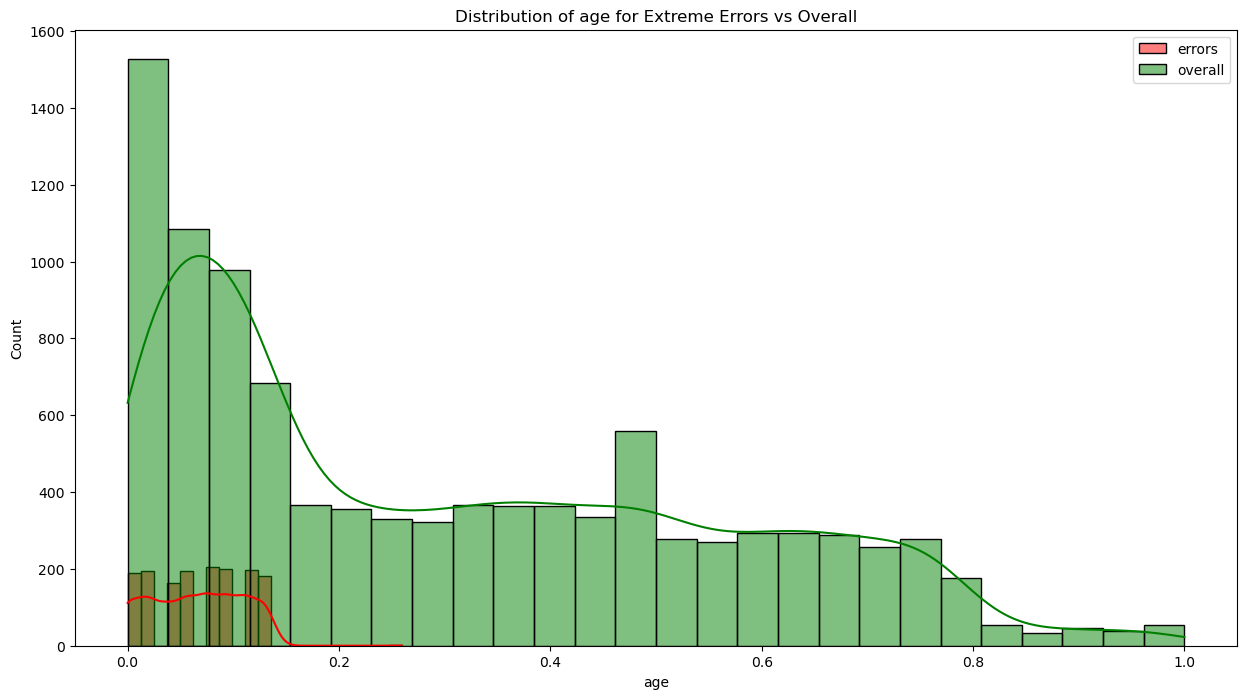

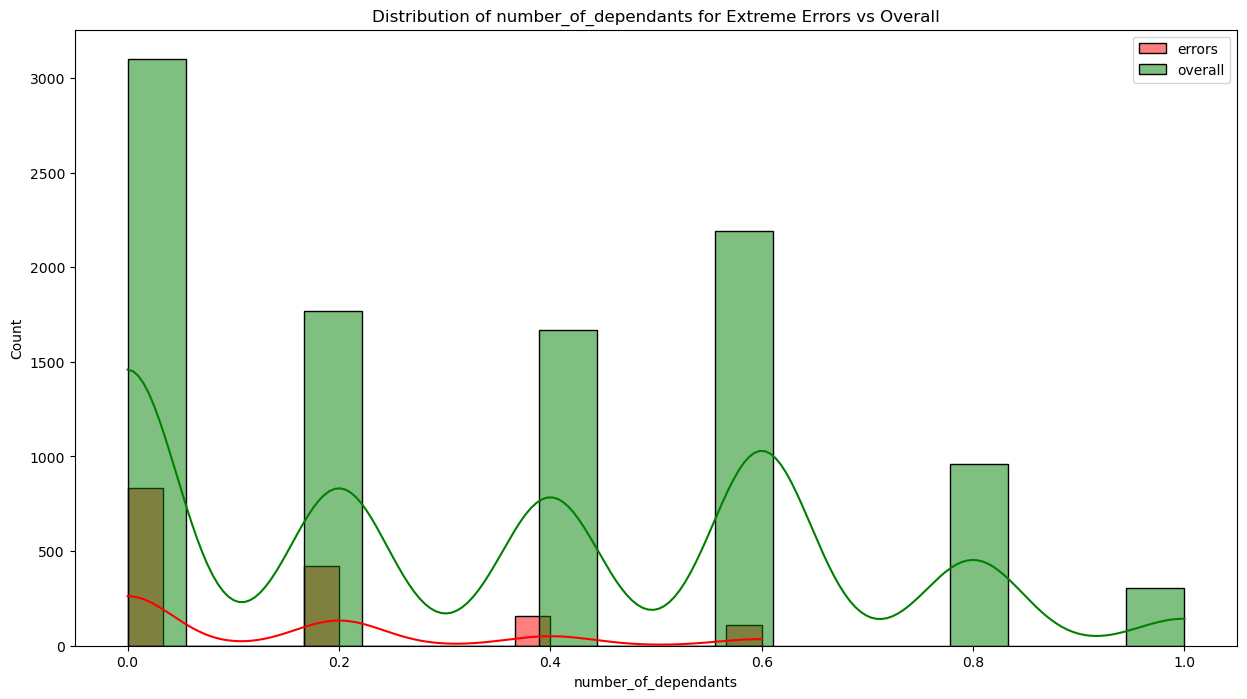

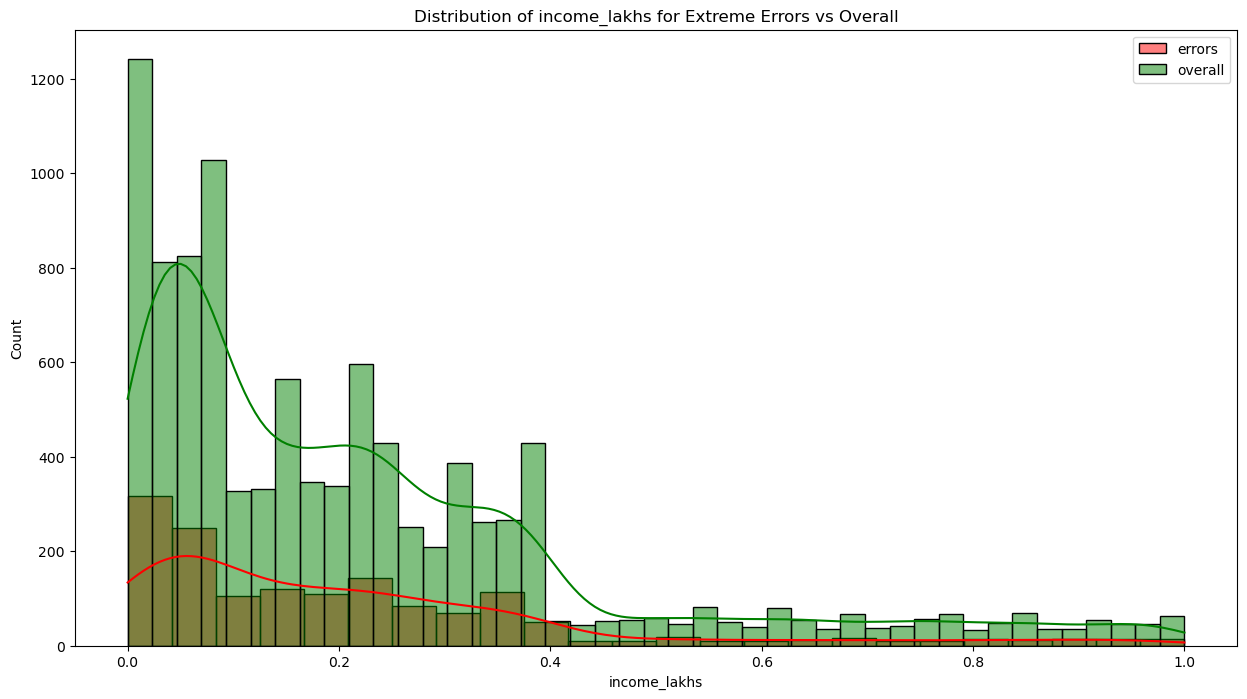

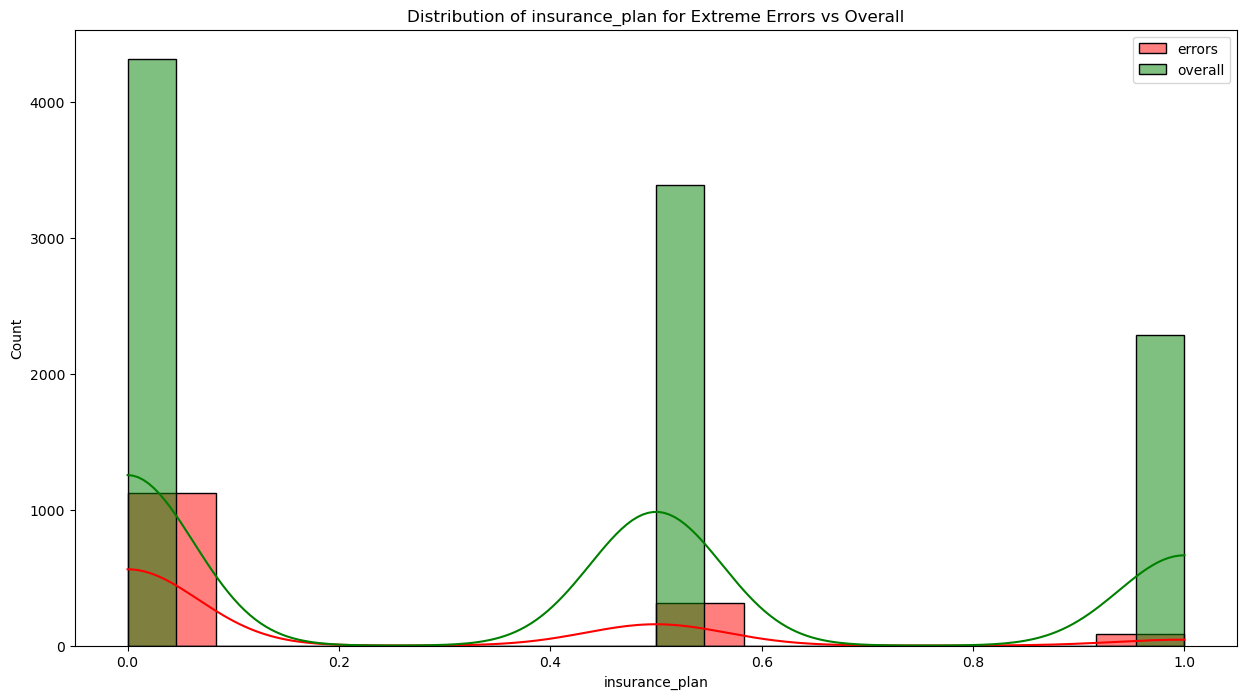

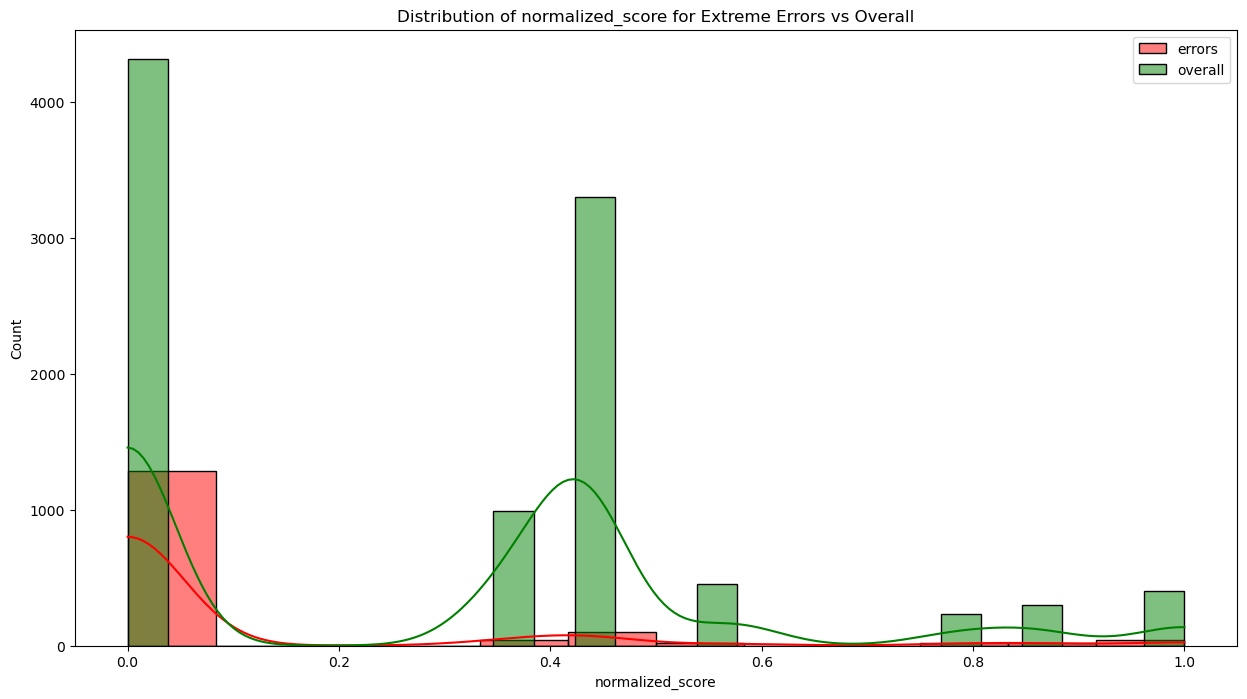

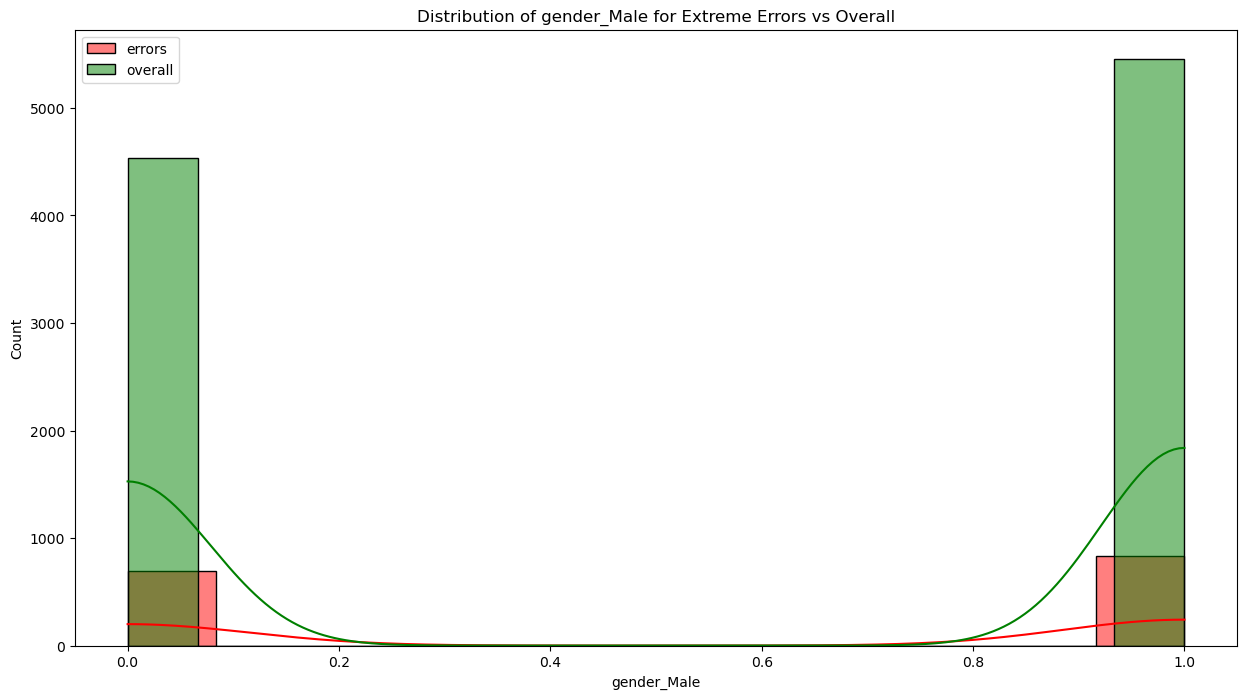

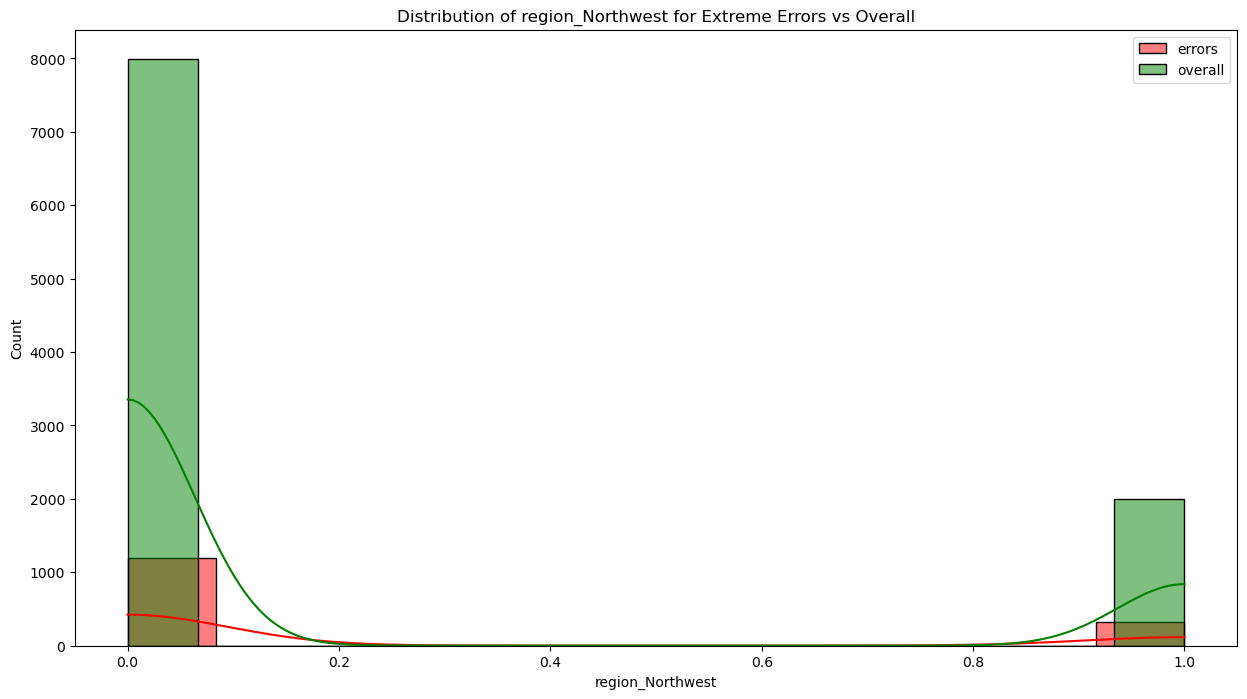

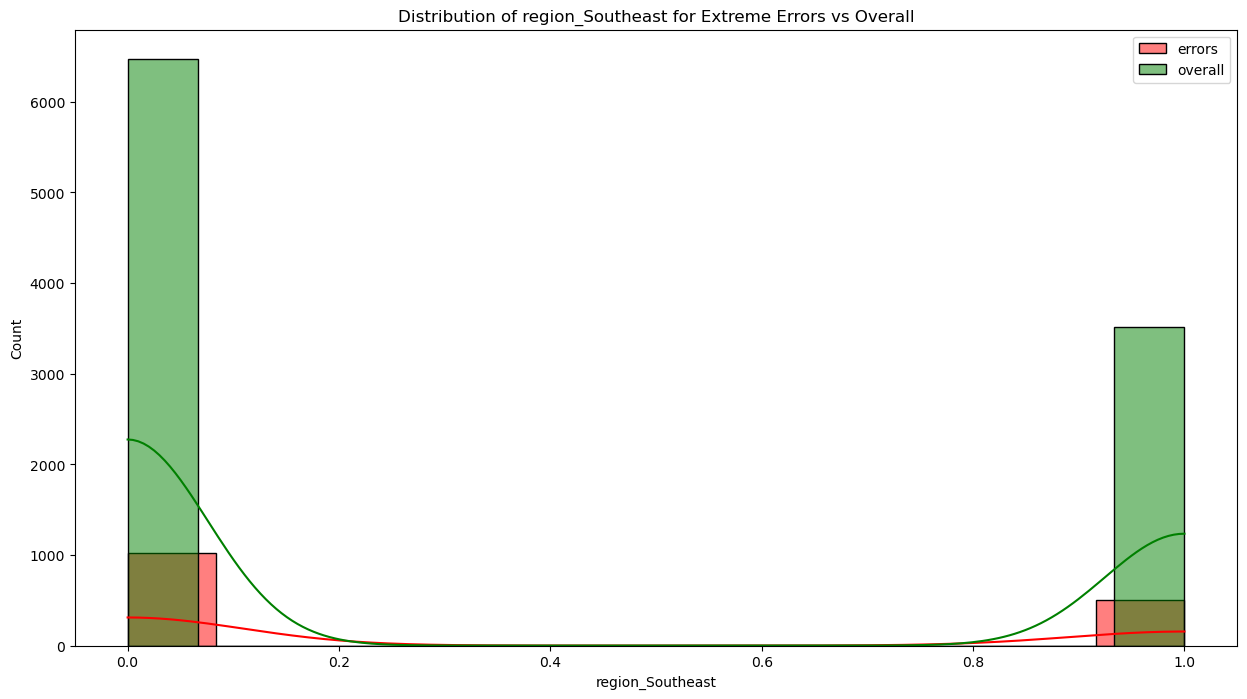

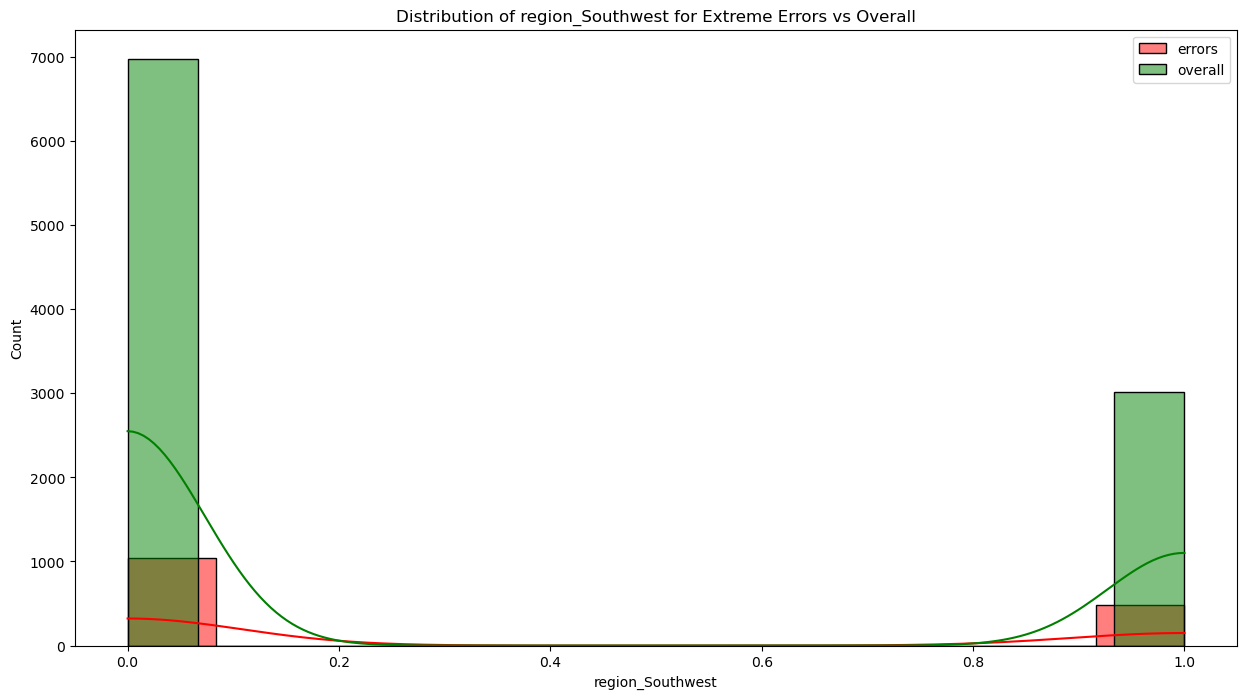

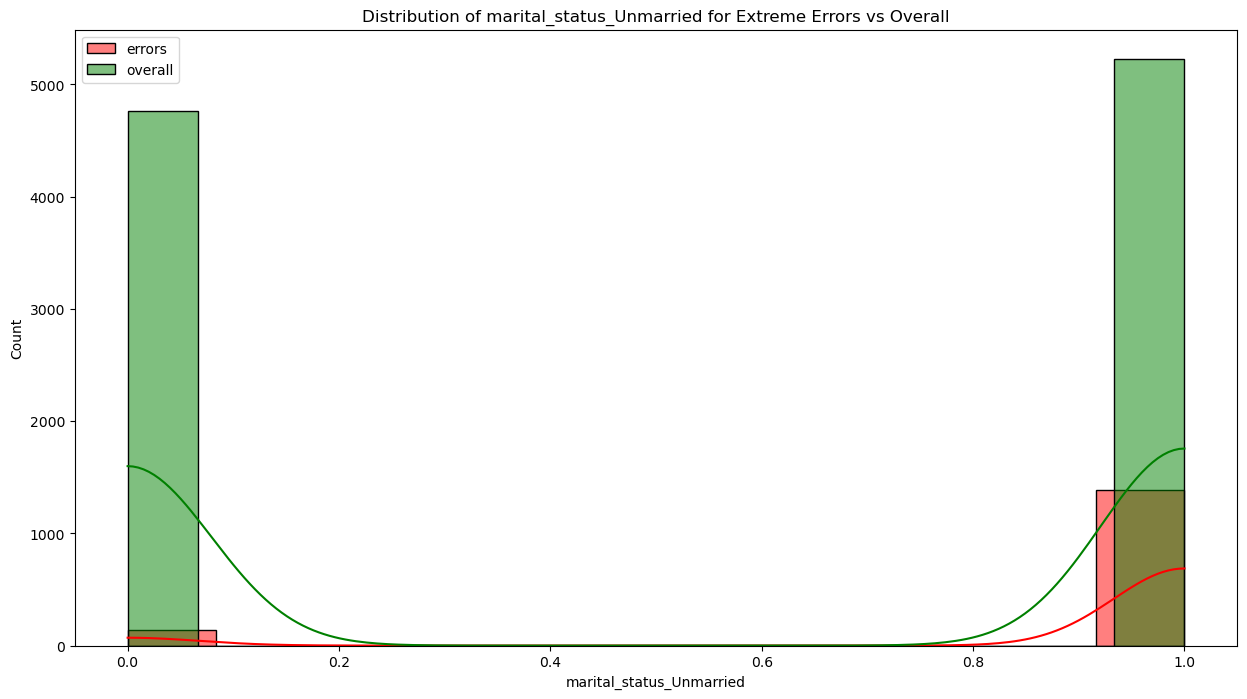

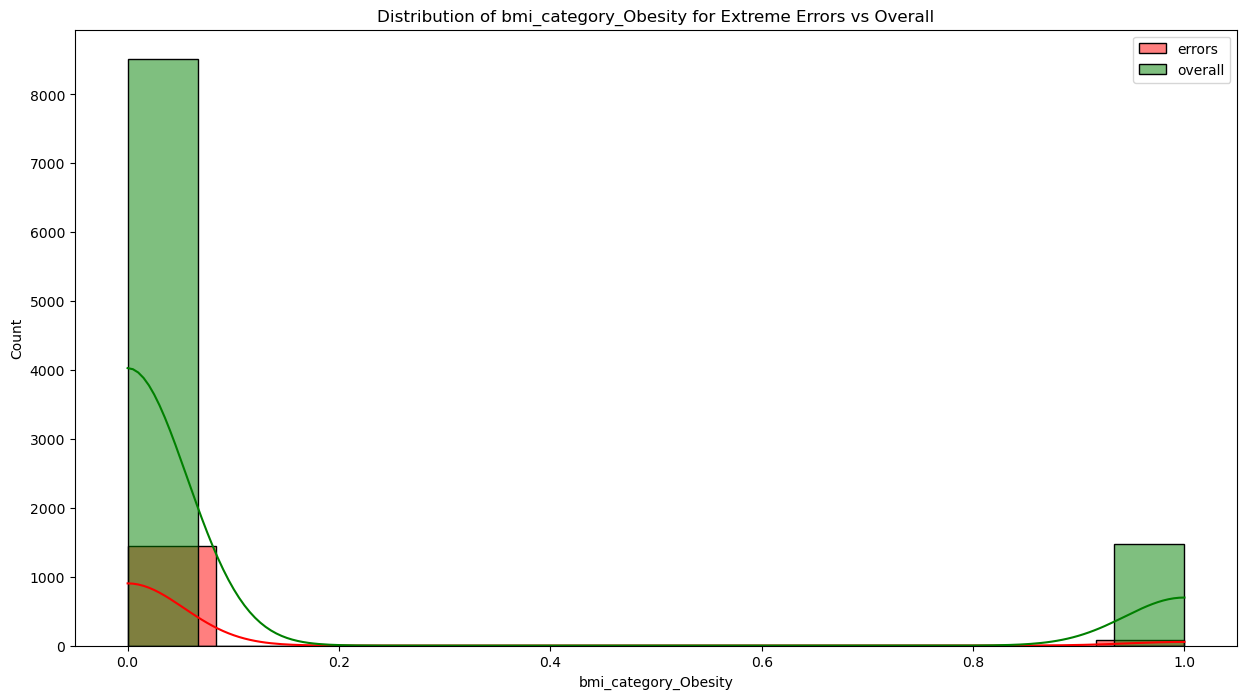

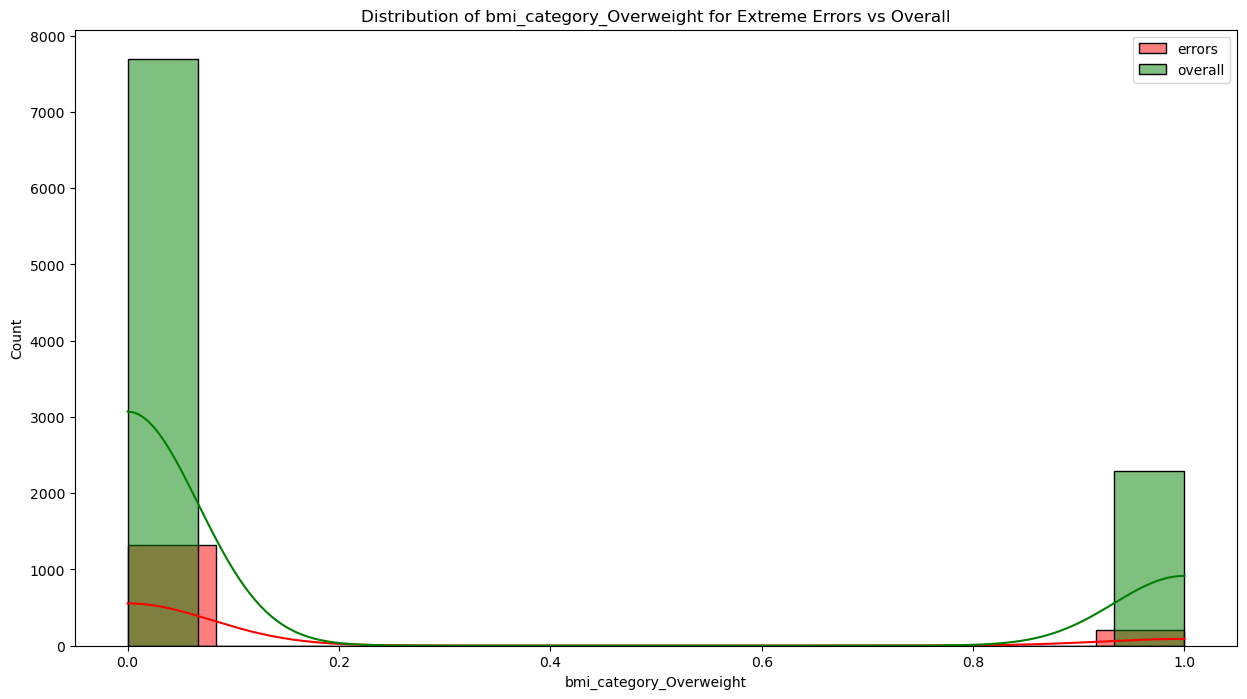

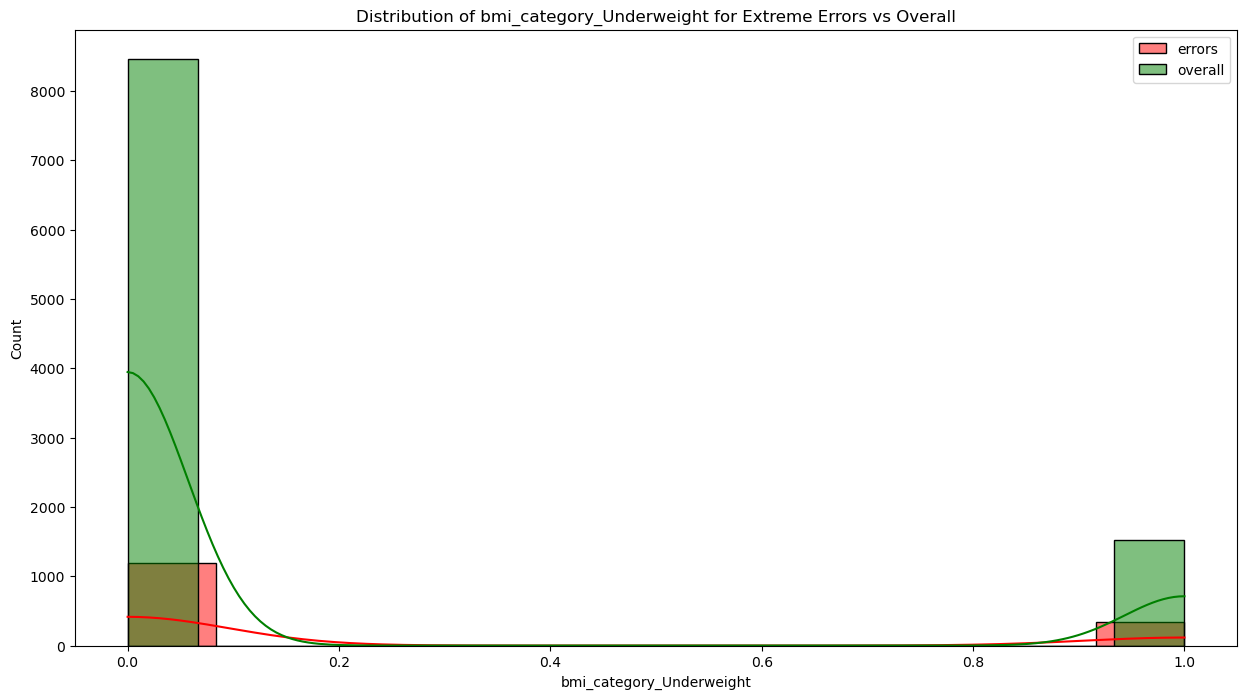

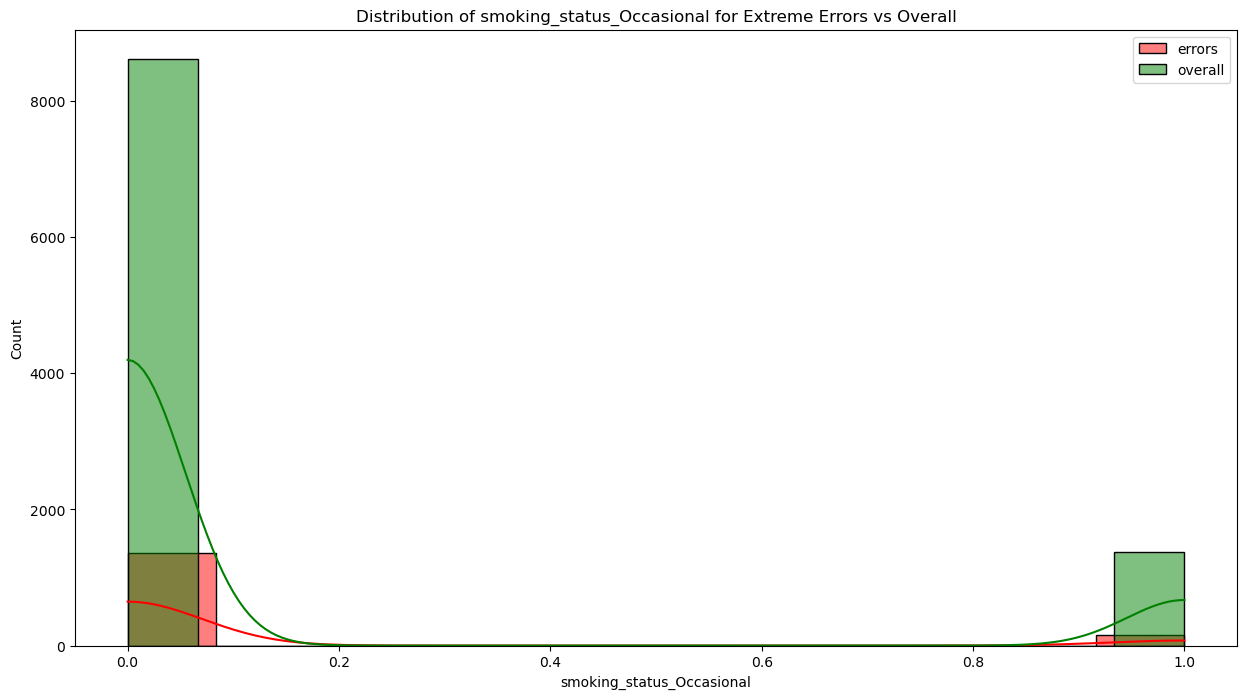

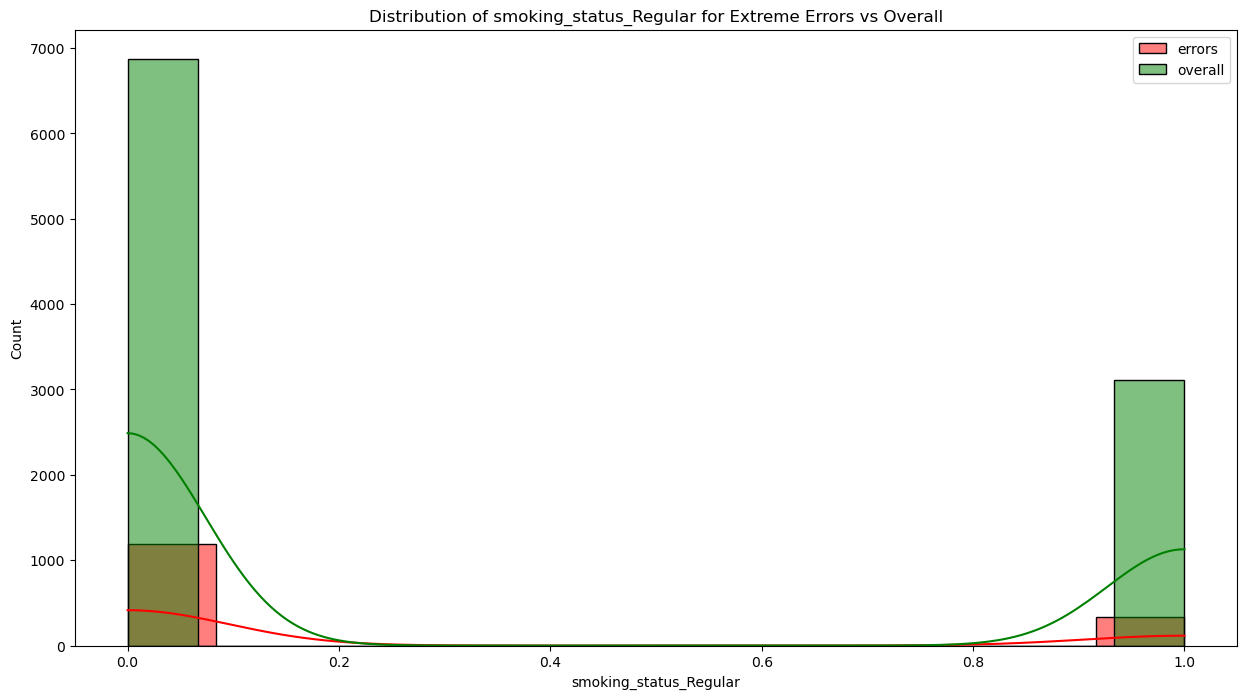

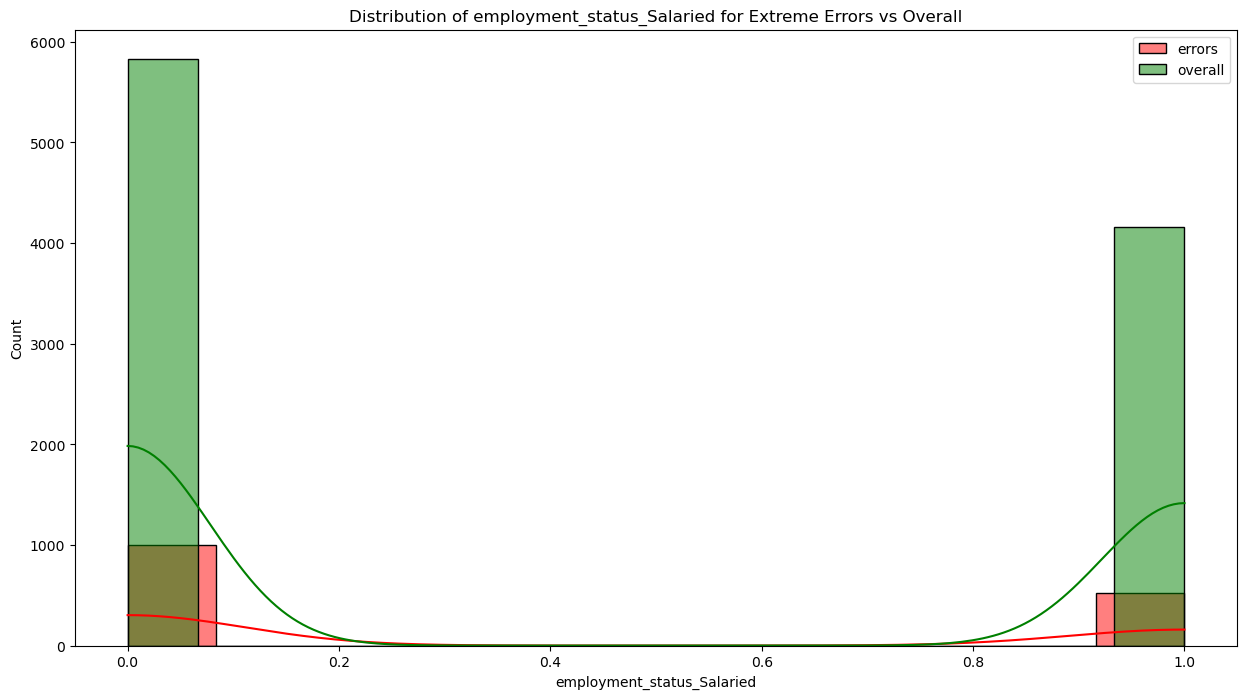

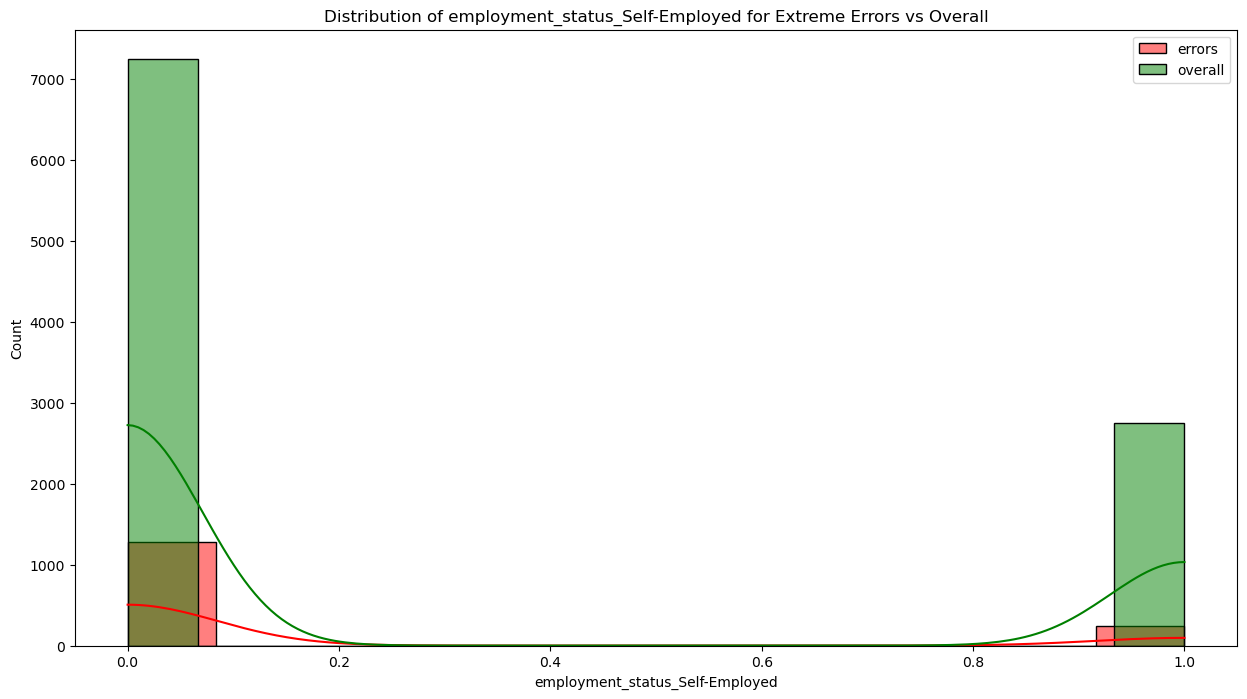

In [364]:
for col in extreme_errors.columns:
    plt.figure(figsize=(15,8))
    sns.histplot(x= col, data= extreme_errors, kde=True, color= "red", label="errors")
    sns.histplot(x= col, data= X_test, kde=True, color= "green",label="overall")
    plt.legend()
    plt.title(f'Distribution of {col} for Extreme Errors vs Overall')
    plt.show()

if you see almost all errors are concentrated of younger age let us do reverse scaling and observe it

In [373]:
extreme_errors['income_level']=-1

In [375]:
df_reversed = pd.DataFrame()
df_reversed[columns_to_scale] = scaler.inverse_transform(extreme_errors[columns_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,22.0,1.0,-2.0,16.0,2.0
1,21.0,0.0,-2.0,31.0,1.0
2,24.0,0.0,-2.0,3.0,1.0
3,24.0,2.0,-2.0,8.0,2.0
4,24.0,1.0,-2.0,2.0,1.0


<Axes: xlabel='age', ylabel='Count'>

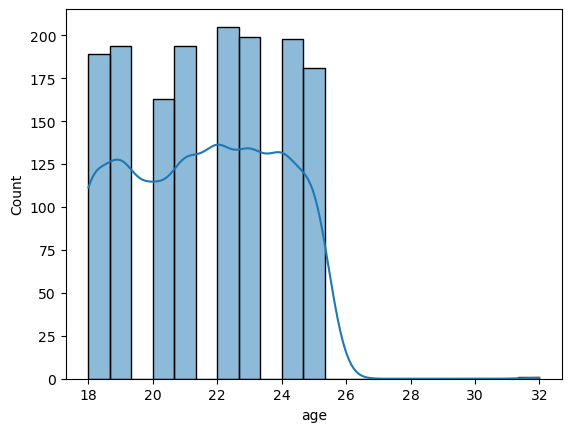

In [376]:
sns.histplot(df_reversed['age'], kde=True)

see most of the errors are from younger age, let us seperate the dataset into two parts younger and older